# Forecasting with statistical models

Statistical models such as [ARIMA](./forecasting-sarimax-arima.html), [SARIMAX](./forecasting-sarimax-arima.html), and [Exponential Smoothing](./forecasting-ets.html) have served as the backbone of time series analysis for decades. While machine learning models typically frame forecasting as a tabular regression problem (mapping $X$ to $y$), statistical models are designed to explicitly capture the underlying stochastic processes of a series, including **stationarity**, **seasonality**, and **autocorrelation**.

Integrating these traditional methods into the forecasting workflow offers several key advantages:

+ **Robustness with limited data:** Statistical methods often outperform machine learning when historical data is scarce or when the series exhibits a highly stable, dominant seasonal pattern.

+ **Interpretability and simplicity:** With fewer parameters and well-understood linear relationships, these models are often easier to explain to stakeholders than "black-box" ensembles.

+ **Rigorous benchmarking:** They provide a critical baseline. Before deploying a complex Gradient Boosting Machine (GBM), it is essential to verify if the added complexity provides significant value over a simpler, traditional approach.

+ **Probabilistic foundations:** Many statistical models are inherently probabilistic, providing reliable **confidence intervals** and **uncertainty quantification** natively.

One of the primary challenges in the Python ecosystem is that statistical libraries often lack a unified API. Unlike the scikit-learn ecosystem, each library typically follows its own convention, making it difficult to switch between models or integrate them into a standardized pipeline. **skforecast** bridges this gap in two ways:

+ **Native scikit-learn compatible implementations:** provide efficient implementations of [`Arima`, `Auto Arima`, `SarimaX`](../api/stats.html#skforecast.stats._arima.Arima), [`Ets`, `Auto Ets`](../api/stats.html#skforecast.stats._ets.Ets), and [`ARAR`](../api/stats.html#skforecast.stats._arar.Arar) models that strictly follow the scikit-learn API.

+ **The [`ForecasterStats`](../api/forecasterstats.html) class:** This specialized class acts as a wrapper, allowing the use of one or multiple statistical models while leveraging the full power of the skforecast ecosystem including: **backtesting**, **hyperparameter search**, and **exogenous variable integration**. In addition to the native implementations, ForecasterStats is compatible with other libraries such as statsmodels, sktime and aeon.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
To learn more about modeling time series with statistical models, visit our examples:

<ul>
    <li><a href="https://www.cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html">ARIMA and SARIMAX models with Python</a></li>
    <li><a href="https://cienciadedatos.net/documentos/py73-arar-forecasting-models-python.html">ARAR models with Python</a></li>
    <li><a href="https://cienciadedatos.net/documentos/py76-exponential-smoothing-models.html">ETS models with Python</a></li>
    <li><a href="../faq/benchmark-statistical-models.html">Benchmark of statistical models for forecasting</a></li>
</ul>
</p>
</div>

The following sections focus on how to use ForecasterStats to train an ARIMA model and predict future values.

## ForecasterStats

The [`ForecasterStats`](../api/forecasterstats.html) class allows for the training and validation of statistical models using the skforecast API. It is compatible with several statistical models from different libraries:

+ **skforecast** [Arima, Auto Arima, Sarimax](../api/stats.html#skforecast.stats._arima.Arima), [Ets, Auto Ets](../api/stats.html#skforecast.stats._ets.Ets), [Arar](../api/stats.html#skforecast.stats._arar.Arar)

+ **sktime** [ARIMA](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.arima.ARIMA.html)

+ **Aeon** [ARIMA](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.forecasting.stats.ARIMA.html#arima)

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
Since version <b>0.19.0</b> of skforecast, the class <code>ForecasterSarimax</code> has been deprecated in favor of the new class <code>ForecasterStats</code>, which provides improved performance and broader compatibility with statistical models. Users are encouraged to transition to <code>ForecasterStats</code> for future projects.

</p>
</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Ets, Arar
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, grid_search_stats
from skforecast.plot import set_dark_theme, plot_prediction_intervals
import warnings

set_dark_theme()
warnings.filterwarnings('once')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00', 'Gasolinas']
data.name = 'y'
data.index.name = 'datetime'
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

datetime
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
                 ...     
1989-09-01    687649.2852
1989-10-01    669889.1602
1989-11-01    601413.8867
1989-12-01    663568.1055
1990-01-01    610241.2461
Freq: MS, Name: y, Length: 253, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1983-01-01 00:00:00  (n=169)
Test dates  : 1983-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=84)


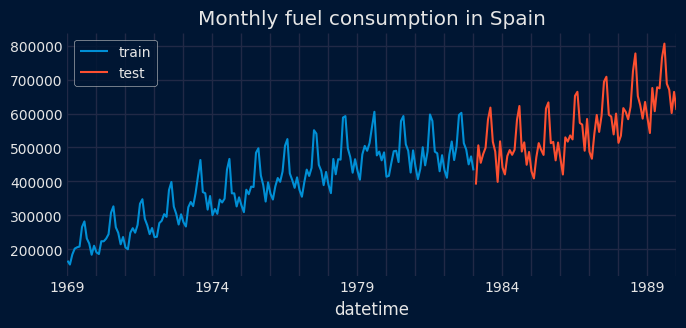

In [3]:
# Split data in train-test partitions
# ======================================================================================
end_train = '1983-01-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

## Training

An ARIMA model is used as estimator within a [`ForecasterStats`](../api/forecasterstats.html) object, allowing us to take advantage of the skforecast functionalities such as backtesting and hyperparameter tuning.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
Skforecast's ARIMA implementation is optimized for speed using Just-In-Time (JIT) compilation with Numba. Consequently, the initial fit of the model is slower due to the overhead of the compilation process; however, subsequent fits and predictions are significantly faster than those of other libraries.
</p>
</div>

In [4]:
# Create and fit ForecasterStats with an ARIMA estimator
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
             )

forecaster.fit(y=data_train, suppress_warnings=True)
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima'] 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1983-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0} 
fit_kwargs: None 
Creation date: 2026-01-31 19:58:55 
Last fit date: 2026-01-31 19:58:56 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1982-04-01', '1982-05-01', '1982-06-01', '1982-07-01',
               '1982-08-01', '1982-09-01', '1982-10-01', '1982-11-01',
               '1982-12-01', '1983-01-01'],
              dtype='datetime64[ns]', name='datetime', length=169, freq='MS') 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

The `suppress_warnings=True` parameter silences convergence warnings and other non-critical messages that may appear during model fitting, keeping the output clean.

## Prediction

In [5]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = forecaster.predict(steps=steps)
predictions.head(3)

1983-02-01    414755.657086
1983-03-01    465102.493791
1983-04-01    504458.858737
Freq: MS, Name: pred, dtype: float64

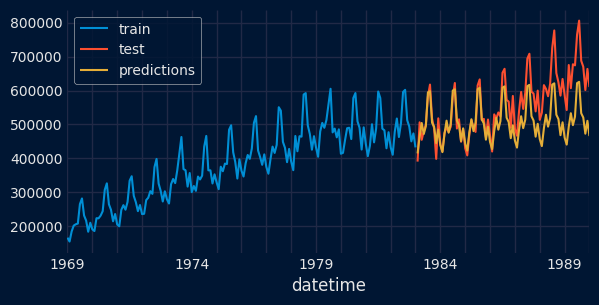

In [6]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions
            )
print(f"Test error (mae): {error_mae}")

Test error (mae): 59203.058715250874


## Prediction intervals

The method `predict_interval` enables the calculation of **prediction intervals** for the forecasted values. Users can specify the confidence level using:

- `alpha`: The **significance level** (e.g., `alpha=0.05` produces a 95% confidence interval)

- `interval`: The **confidence level** directly (e.g., `interval=[2.5, 97.5]` for the same 95% interval)

In [8]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=steps, alpha=0.05)
predictions.head(5)

,pred,lower_bound,upper_bound
1983-02-01,414755.657086,383541.980897,445969.333274
1983-03-01,465102.493791,431519.674752,498685.312829
1983-04-01,504458.858737,469463.167098,539454.550376
1983-05-01,472054.363692,435480.362414,508628.364969
1983-06-01,494879.128788,456858.949999,532899.307577


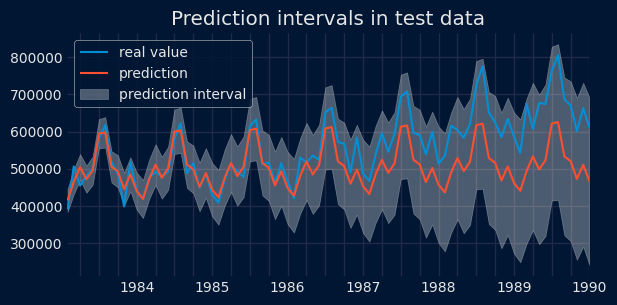

In [9]:
# Plot prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "y",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'white', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)

## Feature importances

For the ARIMA model, the method `get_feature_importances` returns the **estimated coefficients** of the model (AR, MA, and seasonal components). These coefficients indicate the weight assigned to each lag term in the model's equations.

In [10]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,sar1,-0.138924
1,ar1,-0.308182
2,sma1,-0.558172
3,ma1,-0.558438


## Backtesting

One advantage of encapsulating statistical models within the `ForecasterStats` class is that they can be evaluated using any of the [backtesting strategies](../introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0 ; color:inherit;">
<b>Why do statistical models require refitting during backtesting?</b>
</p>

<p>
Unlike machine learning models, statistical models like ARIMA maintain an internal state that depends on the sequence of observations. They can only generate predictions starting from the last observed time step — they cannot "jump" to an arbitrary point in the future without knowing all previous values.

During backtesting, when the validation window moves forward, the model must be refitted to incorporate the new observations and update its internal state. This is why <code>refit=True</code> is typically required.

<b>Performance optimization:</b> Because refitting is mandatory, skforecast's Numba-optimized backend becomes essential. It enables hundreds of refits during backtesting in a fraction of the time required by non-optimized libraries.

<b>Exception:</b> The <code>skforecast.stats.Sarimax</code> model implements an efficient state-space representation that allows updating predictions without full model refitting.
</p>

</div>

In [11]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterStats(
    estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12)
)

cv = TimeSeriesFold(
         steps              = 12,  # predict 12 months per fold
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data,
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 169
Number of observations used for backtesting: 84
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 -- 1985-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1985-01-01 00:00:00  (n=193)
    Validation: 1985-02-01 00:00:00 -- 1986-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1986-01-01 00:00:00  (n=205)
    Validation: 1986-02-01 00:00:00 -- 1987-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1987-01-01 00:00:00  (n=217)
    Validation: 1987-02-0

  0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
# Backtest predictions
# ==============================================================================
predictions.head(4)

,fold,pred
1983-02-01,0,414755.657086
1983-03-01,0,465102.493791
1983-04-01,0,504458.858737
1983-05-01,0,472054.363692


In [13]:
# Bactesting metrics
# ==============================================================================
metric

,mean_absolute_error
0,25776.610245


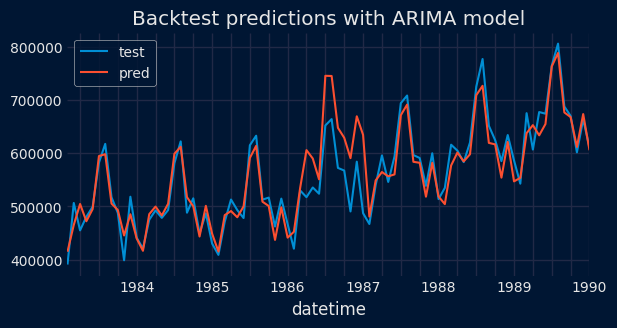

In [14]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

### The freeze_params argument

For models that perform **automatic selection** (AutoArima, AutoETS), re-running the selection procedure in every backtesting fold can be computationally expensive. The `freeze_params` argument in the `backtesting_stats` function controls this behavior:

+ `freeze_params = True` (default): The model parameters found during the **first fit** (e.g., `order` and `seasonal_order` for ARIMA) are **reused in all subsequent refits**. Only the coefficients are re-estimated with new data. This significantly **reduces runtime**.

+ `freeze_params = False`: Automatic model selection is performed **independently in each refit**, allowing parameters to adapt across folds. This increases runtime but may capture **structural changes** in the data. A `params` column is added to the output showing the parameters selected per fold.

## Model tuning

To find the optimal hyperparameters for statistical models, two approaches are widely used:

+ **Statistical Criteria:** Information criteria, such as **Akaike's Information Criterion (AIC)** or **Bayesian Information Criterion (BIC)**, apply different penalties to the maximum likelihood (log-likelihood) estimate to measure model fit. The advantage of these criteria is that they are computed solely on the training data, eliminating the need for out-of-sample predictions. Consequently, the optimization process is significantly accelerated. The well-known AutoArima and AutoETS algorithms use this approach.

+ **Validation Techniques:** Utilizing validation techniques, [backtesting](../user_guides/hyperparameter-tuning-and-lags-selection.html), is another effective strategy. Backtesting evaluates model performance using **independent partitions of historical data** to simulate real-world conditions. This provides a practical assessment of how hyperparameters perform across different time windows.

In the first approach, calculations are based solely on training data, eliminating the need for a separate data partition. This makes the optimization process extremely efficient. However, it is important to note that information criteria only measure the **relative quality** of models within the defined search space. A model with the lowest AIC could still be a poor fit in absolute terms. Therefore, the selected model should ideally undergo a **backtesting phase**. This phase calculates forecast error metrics (such as MAE, MSE, or MAPE) to validate performance on a meaningful, interpretable scale.

### AutoArima

**AutoArima** is an algorithm designed to automate the selection of optimal hyperparameters for an ARIMA model. The algorithm systematically evaluates various combinations of **non-seasonal parameters** ($p, d, q$), **seasonal parameters** ($P, D, Q$), and the **seasonal period** ($m$) to identify the configuration that best fits the data based on a specified criterion, typically the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

Skforecast's [`Arima`](./forecasting-sarimax-arima.html) class triggers the **AutoArima** functionality whenever the `order` or `seasonal_order` arguments are set to `None`. After the model is fitted, the optimal parameters can be accessed via the `best_params_` attribute. 

For all subsequent predictions, the model **automatically utilizes the optimal configuration** identified during the fitting process. This functionality is also available in the [`Ets`](./forecasting-ets.html) when `model` is set to `None` or to `'ZZZ'`.

In [15]:
# Skforecast Auto Arima
# ==============================================================================
auto_arima = Arima(
    order          = None,  # Must be None to use AutoArima
    seasonal_order = None,  # Must be None to use AutoArima
    start_p        = 0,
    start_q        = 0,
    max_p          = 12,
    max_q          = 3,
    max_P          = 2,
    max_Q          = 2,
    max_order      = 5,
    max_d          = 2,
    max_D          = 1,
    ic             = "aic",
    m              = 12,
    trace          = True,  # True for detailed information of the process
)
forecaster = ForecasterStats(estimator=auto_arima)
forecaster.fit(y=data_train, suppress_warnings=True)


Fitting models using approximations...

 ARIMA(p,d,q)(P,D,Q)[m]                     : aic
 ------------------------------------------------
 ARIMA(0,1,0)(1,1,1)[12]                    : 3564.3887
 ARIMA(0,1,0)(0,1,0)[12]                    : 3637.1363
 ARIMA(1,1,0)(1,1,0)[12]                    : 3506.9117
 ARIMA(0,1,1)(0,1,1)[12]                    : 3481.3432
 ARIMA(0,1,1)(0,1,0)[12]                    : 3542.1014
 ARIMA(0,1,1)(1,1,1)[12]                    : 3482.0043
 ARIMA(0,1,1)(0,1,2)[12]                    : 3481.2735
 ARIMA(0,1,1)(1,1,2)[12]                    : 3482.5762
 ARIMA(0,1,0)(0,1,2)[12]                    : 3563.7959
 ARIMA(1,1,1)(0,1,2)[12]                    : 3476.4900
 ARIMA(1,1,1)(0,1,1)[12]                    : 3476.4887
 ARIMA(1,1,1)(0,1,0)[12]                    : 3531.8215
 ARIMA(1,1,1)(1,1,1)[12]                    : 3477.1082
 ARIMA(1,1,1)(1,1,0)[12]                    : 3493.3277
 ARIMA(1,1,1)(1,1,2)[12]                    : 3478.4277
 ARIMA(1,1,0)(0,1,1

In [16]:
# Access the optimal parameters selected by AutoArima
# ==============================================================================
print(f"Best parameters: {forecaster.estimators_[0].best_params_}")

Best parameters: {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1), 'm': 12}


In [17]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = forecaster.predict(steps=steps)
predictions.head(3)

# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions
            )

print(f"Test error (mae): {error_mae}")

Test error (mae): 53517.26243040556


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When evaluating ARIMA-SARIMAX models, it is important to note that AIC assumes that all models are trained on the same data. Thus, using AIC to decide between different orders of differencing is technically invalid, since one data point is lost with each order of differencing. Therefore, the Auto Arima algorithm uses a unit root test to select the order of differencing, and only uses the AIC to select the order of the AR and MA components.

For a detailed explanation of Akaike's Information Criterion (AIC) see <a href="https://robjhyndman.com/hyndsight/aic/">Rob J Hyndman's blog</a> and <a href="https://sites.warnercnr.colostate.edu/kenburnham/wp-content/uploads/sites/25/2016/08/AIC-Myths-and-Misunderstandings.pdf">AIC Myths and Misunderstandings by Anderson and Burnham</a>.

</div>

### Grid search with backtesting

Although less common in the context of statistical models, it is also possible to use **grid search** and **random search** to find optimal hyperparameters. It is crucial to conduct the search using a **validation dataset**, rather than the test dataset, to ensure an accurate and unbiased evaluation of model performance.

The training partition is split again to separate a **validation partition**, which is used for the hyperparameter search. The **test partition** remains untouched and is reserved exclusively for the final evaluation of the model's performance.

In [18]:
# Split Train-validation-test data
# ======================================================================================
end_train = '1979-01-01 23:59:59'
end_val   = '1983-01-01 23:59:59'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

Train dates      : 1969-01-01 00:00:00 --- 1979-01-01 00:00:00  (n=121)
Validation dates : 1979-02-01 00:00:00 --- 1983-01-01 00:00:00  (n=48)
Test dates       : 1983-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=84)


In [19]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 0, 0))  # Placeholder replaced in the grid search
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0,), (0, 1, 0), (1, 1, 1)],
    'm': [1, 12]
}

cv = TimeSeriesFold(steps=12, initial_train_size=len(data.loc[:end_train]))

results_grid = grid_search_stats(
                   forecaster        = forecaster,
                   y                 = data.loc[:end_val],
                   param_grid        = param_grid,
                   cv                = cv,
                   metric            = 'mean_absolute_error',
                   return_best       = True,
                   n_jobs            = 'auto',
                   suppress_warnings = True,
                   verbose           = False,
                   show_progress     = True
               )
results_grid.head(5)

Number of models compared: 30.


params grid:   0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'m': 12, 'order': (0, 1, 0), 'seasonal_order': (1, 1, 1)}
  Backtesting metric: 17746.438118342612



,params,mean_absolute_error,m,order,seasonal_order
0,"{'m': 12, 'order': (0, 1, 0), 'seasonal_order'...",17746.438118,12,"(0, 1, 0)","(1, 1, 1)"
1,"{'m': 12, 'order': (1, 1, 0), 'seasonal_order'...",18100.683177,12,"(1, 1, 0)","(1, 1, 1)"
2,"{'m': 12, 'order': (1, 1, 1), 'seasonal_order'...",18591.412656,12,"(1, 1, 1)","(1, 1, 1)"
3,"{'m': 12, 'order': (0, 1, 1), 'seasonal_order'...",19638.353224,12,"(0, 1, 1)","(1, 1, 1)"
4,"{'m': 12, 'order': (2, 1, 1), 'seasonal_order'...",21982.623994,12,"(2, 1, 1)","(1, 1, 1)"


Since `return_best = True`, the Forecaster object is **updated with the most optimal configuration** found and **trained with the entire dataset**.

In [20]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = forecaster.predict(steps=steps)
predictions.head(3)

# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions
            )

print(f"Test error (mae): {error_mae}")

Test error (mae): 53646.64174573329


## Multiple estimators

`ForecasterStats` supports **multiple statistical estimators**, allowing users to train, predict, and compare several models within a single workflow. This guarantees that all models operate on the same data partitions and time indices, making comparisons fair and reproducible.

Furthermore, combining predictions from multiple models (**ensembling**) is a well-established technique that often improves forecasting accuracy compared to relying on a single model.

In [21]:
# Forecaster with multiple statistical models as estimators
# ==============================================================================
estimators = [
    Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
    Ets(m=12, model="MAM"),
    Arar()
]
forecaster = ForecasterStats(estimator=estimators)

forecaster.fit(y=data_train, suppress_warnings=True)
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima', 'skforecast.Ets', 'skforecast.Arar'] 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1983-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0}
    skforecast.Ets: 
        {'m': 12, 'model': 'MAM', 'damped': None, 'alpha': None, 'beta': None,
        'gamma': None, 'phi': None, 'seasonal': True, 'trend': None,
        'allow_multiplicative': True, 'allow_multiplicative_trend': False}
    skforecast.Arar: {'max_ar_depth': 26, 'max_lag': 40, 'safe': True} 
fit_kwargs: None 
Creation date: 2026-01-31 19:59:09 
Last fit date: 2026-01-31 19:59:13 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1982-04-01', '1982-05-01', '1982-06-01', '1982-07-01',
               '1982-08-01', '1982-09-01', '1982-10-01', '1982-11-01',
               '1982-12-01', '1983-01-01'],
              dtype='datetime64[ns]', name='datetime', length=169, freq='MS') 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

In [22]:
# Prediction with multiple estimators
# ==============================================================================
predictions = forecaster.predict(steps=len(data_test))
predictions.head(6)

,estimator_id,pred
1983-02-01,skforecast.Arima,414755.657086
1983-02-01,skforecast.Ets,408101.282195
1983-02-01,skforecast.Arar,409292.695102
1983-03-01,skforecast.Arima,465102.493791
1983-03-01,skforecast.Ets,468889.543146
1983-03-01,skforecast.Arar,474934.656818


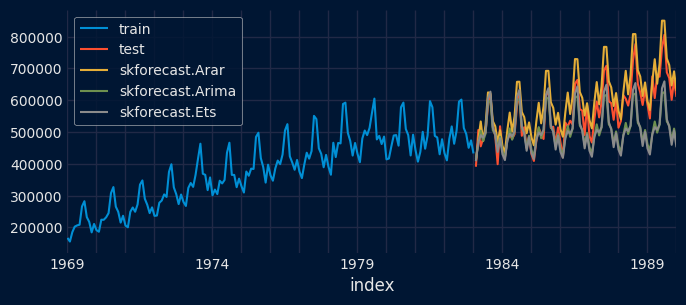

In [23]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
(
    predictions
    .reset_index()
    .pivot(index='index', columns='estimator_id', values='pred')
    .plot(ax=ax)
)
ax.legend();

`ForecasterStats` assigns a **unique identifier** and a **name** to each model passed as an estimator. While the IDs remain constant to ensure consistent tracking, if AutoArima or AutoETS is triggered, the names are **automatically updated after fitting** to reflect the specific parameters of the selected estimators.

In [24]:
# Access estimators information
# ==============================================================================
print(f"Estimators       : {forecaster.estimators_}")
print(f"Estimators id    : {forecaster.estimator_ids}")
print(f"Estimators names : {forecaster.estimator_names_}")

Estimators       : [Arima(1,1,1)(1,1,1)[12], Ets(model=MAM, m=12, damped=None, alpha=None, beta=None, gamma=None, phi=None, lambda_param=None, lambda_auto=False, bias_adjust=True, bounds='both', seasonal=True, trend=None, ic='aicc', allow_multiplicative=True, allow_multiplicative_trend=False), Arar(lags=(1, 2, 12, 13))]
Estimators id    : ['skforecast.Arima', 'skforecast.Ets', 'skforecast.Arar']
Estimators names : ['Arima(1,1,1)(1,1,1)[12]', 'Ets(MAM)', 'Arar(lags=(1, 2, 12, 13))']


A detailed summary of all estimators included in the forecaster can be accessed using the `get_estimators_info()` method.

In [25]:
# Information of the estimators included in the forecaster
# ==============================================================================
forecaster.get_estimators_info()

,id,name,type,supports_exog,supports_interval,params
0,skforecast.Arima,"Arima(1,1,1)(1,1,1)[12]",skforecast.stats._arima.Arima,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
1,skforecast.Ets,Ets(MAM),skforecast.stats._ets.Ets,False,True,"{'m': 12, 'model': 'MAM', 'damped': None, 'alp..."
2,skforecast.Arar,"Arar(lags=(1, 2, 12, 13))",skforecast.stats._arar.Arar,True,True,"{'max_ar_depth': 26, 'max_lag': 40, 'safe': True}"


Other methods that allow for the access and manipulation of estimators include `get_estimator()`, `remove_estimators()`, and `set_params()`. Visit [`ForecasterStats API`](../api/forecasterstats.html).

## Exogenous variables

**Exogenous variables** can be incorporated into the model using the `exog` argument. The primary requirement for including an exogenous variable is that its values must be **known for both the training period and the entire forecast horizon**.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [26]:
# Create calendar features to be used as exogenous variables
# ==============================================================================
data_exog = pd.DataFrame(
    {'y': data.to_numpy(), 'month': data.index.month},
    index = data.index
)
end_train = '1980-01-01 23:59:59'
data_exog_train = data_exog.loc[:end_train]
data_exog_test  = data_exog.loc[end_train:]
data_exog.head()

,y,month
datetime,,
1969-01-01,166875.2129,1
1969-02-01,155466.8105,2
1969-03-01,184983.6699,3
1969-04-01,202319.8164,4
1969-05-01,206259.1523,5


In [27]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
             )
forecaster.fit(
    y                 = data_exog_train['y'], 
    exog              = data_exog_train['month'],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_exog_test['month']
              )
predictions.head(3)

1980-02-01    422825.805875
1980-03-01    486540.206317
1980-04-01    487971.238942
Freq: MS, Name: pred, dtype: float64

## Prediction on training data (In-sample Predictions)

**In-sample predictions** are crucial for evaluating the accuracy and effectiveness of the model. By comparing the predicted values with the actual observed values in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identify areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the historical data on which it was trained.

Predictions of the observations used to fit the model are stored in the `fitted_values_` attribute of the `Arima` object.

In [28]:
# Create and fit ForecasterStats (skforecast)
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
# Show only the first 5 values 
forecaster.estimators_[0].fitted_values_[:5]

array([166778.86748562, 155441.28198886, 184949.38956579, 202282.72293861,
       206228.03030826])